## Deadline

Wednesday, November 22, 2017, 11:59PM

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?


#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


___
___
___


Importing the libraries we will need for the homework

In [151]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy import sparse

import itertools

%matplotlib inline

## Question 1: Resolution

### Thought process and Implementation plan:
The objective of this exercise is to analyze the effect of a training program on an individual's earnings. 

** Loading and Cleaning the Dataset ** 

The dataset is provided in a csv file containing the suss-mentioned categories : 
- *treat* : whether the subject followed the tranining program, binary value
- *age* : the age of the subject
- *educ* : the number of years of education 
- *race* : Black, White or Hispanic
- *married* : whether the subject is married or not, binary value
- *nodegree* : whether the subject has a degree (1 if they don't, 0 if they do)
- *re74*, *re75* and *re78*: earnings for the given year

The dtypes and unique values of the columns were verified to make sure that there weren't any suprises along the way. 

When looking at the data we noticed that there wasn't a white column. This column was added manually and individuals were set to 1 if they were neither black nor hispanic. We also added a race column which would take values B,H,W whether the person was black, hispanic or white.

**1. Naive Analysis**

The objective here was to quickly assess whether having followed the training program had an influence on the salary. Therefore we wanted to compare simply the *re78* for people with and without treatment. For that we used the groupby functionality. To obtain statistical information we used the describe functionality of the dataframes and computed the correlation between having taken the treatment and the salary. We plotted the histograms of the data with treatment, without treatment and overall with a boxplot to explicit certain statistical aspects of the data. We also plotter the boxplots of with and without treatment against one another with a swarmplot to determine where the datapoints lie. All of this was done with multiple functions so that they can be reused in following questions


**2. Closer Look **

We conducted similar tests but with all the features this time combining visualization of multiple boxplots with descriptions of all the variables, notably the categorical ones which required slightly different handling 


**3. Propensity Score Model**

Using the cleaned data we can now determine the propensity score, which is to say the probability of receiving treatment given the pre-treatment features. This is done using logistic regression as shown during the Tutorial : 
1. Create feature vectors with dummy
2. Normalize the feature vectors
3. Create the logistic regression model
4. Get the predictions
5. Threshold to get estimate labels
6. Compute the confusion matrix to assess quality of the regression

**4. Balancing the Dataset Via Matching**

In order to do the feature matching, and following the recommendation to use networkx, we first needed to create a connected graph from our observations : 
1. Create a bipartite graph 
2. Add edges between the nodes from the different partitions using the inverse of the differences in propensity scores from the previous question
3. Used the networkx max_weight_matching algorithm on the bipartite graph in order to find the optimal pairs. Maximizing the weights is equivalent to minimizing the difference in propensity scores between the matched pairs. 

We then observed the feature distributions for the new dataframe containing only the matched pairs. We noticed that there was a big imbalance in terms of race. That is why we had to recompute the matching. 

**5. Balancing Groups Further**

The idea here was to force the matching of the race. That is why we did the matching for each race individually before combining all the results into one final dataframe. The distributions were then observed using the plotting and description functions and were found to be sound.

**6. A Less Naive Analysis**

Using the same functions as in question 1 we observe the distribution of revenues for 78 for treated and not treated individuals.

___
___
___




### 1.0 Loading the Dataset


In [39]:
# Loading the csv file
data = pd.read_csv("lalonde.csv")

# Adding the white column
data['white'] = (data["black"] + data["hispan"]<1).astype(int)

# Adding a "race" column
data['race'] = "unknown"
data.loc[data["white"] ==1, 'race'] = "W"
data.loc[data["hispan"] ==1, 'race'] = "H"
data.loc[data["black"] ==1, 'race'] = "B"

#Setting the index to the user id
data.set_index("id", inplace = True)

data.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,race
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,B
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,H
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,B
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,B
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,B
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0,B
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0,B
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0,B
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0,B


Functions used for visualizations and descriptions. Not all are used in the homework but were kept in the notebook.

In [203]:
# Testing whether the distribution of the data is normal
def normal_distribution_test(data):
    k2, p = scipy.stats.normaltest(data)
    if p>0.05:
        print("\tThe null hypothesis cannot be rejected\n")
        return False
    else :
        print("\tThe null hypothesis can be rejected\n")
        return True

# Testing whether two datasets come from the same distribution
def same_distribution_test(data1, data2):
    stats, p = scipy.stats.kruskal(data1, data2)
    if p>0.05:
        print("\tThe null hypothesis cannot be rejected\n")
        return False
    else :
        print("\tThe null hypothesis can be rejected\n")
        return True

# Fucntion which tests whether the data is noramlly distributed, whether
# the different categories are individually distribution, whether
# the individual categories come from the same distribution
# and then the correlation between the treatment and the given variable

def statistical_description(df, col):

    print("Testing whether the entire data is normally distributed")        
    all_normal = normal_distribution_test(list(df[col]))
    
    print("Testing whether the results with treatment are normally distributed")        
    treat_normal = normal_distribution_test(list(df.loc[df['treat'] == 1, col]))
    
    print("Testing whether the results without treatment are normally distributed")        
    no_treat_normal = normal_distribution_test(list(df.loc[df['treat'] == 0, col]))
       
    print("Testing whether the data comes from the same distributions")
    same_distribution_test(list(df.loc[df['treat'] == 0, col]),\
                           list(df.loc[df['treat'] == 1, col]))
    
    print("Computing correlation between Treatment and {}".format(col))
    # Taking into account whether the data is normally distributed or not
    # to select the correlatoin type
    if all_normal or (treat_normal and no_treat_normal):
        corr_type = "pearson"   
    else:
        corr_type = "spearman"

    correlation = df[[col, "treat"]].corr(corr_type)
    print("\t{} correlation between treatment and {} : {:4f}".format(corr_type, col, correlation.loc["treat", col]))

# Function used to plot a histogram of the data with the boxplot
def histogram_boxplot(df, col, title):
    # Extract the data for the given columns
    x = list(df[col])
    # Plot the distplot (histogram + trend)
    ax = sns.distplot(x)
    # Add the boxplot to the overall plot
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-.5, 10))  
    ax.set_xlabel(col)
    ax.set_ylabel("percentage")
    ax.set_title(title)

# Function used to plot boxplots with swamplots
def boxplot_with_swarmplot(df,col):
    df_data = df.copy()
    df_data[col] = df_data[col].astype('category')
    try:
        ax = sns.boxplot(x=col, y="treat", data=df_data, orient="h")
        ax = sns.swarmplot(x=col, y="treat", data=df_data, color=".25", orient="h")
    except:
        df_data[col] = df_data[col].cat.codes
        ax = sns.boxplot(x=col, y="treat", data=df_data, orient="h")
        ax = sns.swarmplot(x=col, y="treat", data=df_data, color=".25", orient="h")

# Function used to plot the boxplots and histogram distributions for a given 
# column with and without treatment.
def plot_distritbution_for_col(df, col):
    plt.figure(figsize=(10, 10))
    
    # Histograms with boxplots and distribution
    plt.subplot(2,2,1)
    histogram_boxplot(df.loc[df["treat"] == 1], col, "With Treatment")
    
    plt.subplot(2,2,2)
    histogram_boxplot(df.loc[df["treat"] == 0], col, "Without Treatment")
    
    plt.subplot(2,2,3)
    histogram_boxplot(df, col, "With and Without Treatment")
    
    # Boxplots with datapoints
    plt.subplot(2,2,4)
    boxplot_with_swarmplot(df,col)
    
    plt.tight_layout()

# Function used to plot the distributions for non categorical variables
def plot_distribution_for_non_categorical_variables(df):
    plt.figure(figsize=(10, 10))

    for idx,col in enumerate(["age", "educ","re74","re75","re78"]):
        if col in ["age", "educ"]:
            plt.subplot(4,2,idx+1)
        else:
            plt.subplot(4,1,idx)
            plt.xlim(0,61000)
        boxplot_with_swarmplot(df,col)

    plt.tight_layout()
    
# Function used to plot the distributions for categorical variables
def plot_distributions_for_categorical_variables(df):
    fig = plt.figure(figsize = (20,5))
    for i, attribute in enumerate(["married", "nodegree", "race"]):
        ax = plt.subplot(1,3,i+1)

        if attribute == "race" :
            ax.hist([df.loc[df["black"] == 1, "treat"],\
                     df.loc[df["white"] == 1, "treat"],\
                     df.loc[df["hispan"] == 1, "treat"]],\
                     color=['r','b', 'g'], alpha=0.5)  
            ax.set_title("Treatment 1 vs. Non Treatment 0")
            ax.legend(["black", "white", "hispan"])
        else :
            
            ax.hist([df.loc[df[attribute] == 1, "treat"],\
                     df.loc[df[attribute] == 0, "treat"]], color=['r','b'], alpha=0.5)  
            ax.set_title("Treatment 1 vs. Non Treatment 0")
            ax.legend([attribute, "Not "+ attribute])
            
    plt.tight_layout;
    print(df[["treat",'black','white','hispan', "nodegree", "married"]].groupby(["treat"]).sum())

**Functions used for computation and visualization of the confusion matrices**

Code taken from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) for visualization of the confusion matrix


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, print_cnf = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if print_cnf:
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Function used to compute all the attributes of the confusion matrix as well as the true positive rates, false positive rates, precision, recall and F1 measure. The function also calls the plotting function above. Note that the function uses the weighted option for precision, recall and f1 score to take into account the fact that the classes are imbalanced.

In [42]:
def my_confusion_matrix(y_test, y_est, classes, print_cnf = True):    
    # Computing the confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_est);
    # Displaying the values 
    if print_cnf:
        print(cnf_matrix)
    # Plotting the confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix', print_cnf = print_cnf);
    # Outputting the TPR, FPR, Precision, Recall, F1
    print("--------------------------")
    if np.shape(cnf_matrix)[0] ==2:
        TPR = cnf_matrix[0,0]/len(prop_data)
        FPR = cnf_matrix[1,0]/len(prop_data)
        print("True Positive Rate: {:.4f}".format(TPR))
        print("False Positive Rate: {:.4f}".format(FPR))
    
    precision = precision_score(y_test, y_est, average='weighted')
    recall = recall_score(y_test, y_est, average='weighted')
    F1 = f1_score(y_test, y_est, average='weighted')
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(F1))

### 1.1. Naive Analysis

** Raw Data **

We started by recovering certain non parametric metrics regarding the raw data and plotting the correponding boxplots

In [43]:
statistical_description(data, "re78")

print("Describing the data with parametric and non parametric metrics")
data[["re78", "treat"]].groupby("treat").describe()

Testing whether the entire data is normally distributed
	The null hypothesis can be rejected

Testing whether the results with treatment are normally distributed
	The null hypothesis can be rejected

Testing whether the results without treatment are normally distributed
	The null hypothesis can be rejected

Testing whether the data comes from the same distributions
	The null hypothesis cannot be rejected

Computing correlation between Treatment and re78
	pearson correlation between treatment and re78 : -0.039033
Describing the data with parametric and non parametric metrics


re78                                                                \
       count         mean          std  min       25%       50%        75%   
treat                                                                        
0      429.0  6984.169742  7294.161791  0.0  220.1813  4975.505  11688.820   
1      185.0  6349.143530  7867.402218  0.0  485.2298  4232.309   9642.999   

                 
            max  
treat            
0      25564.67  
1      60307.93

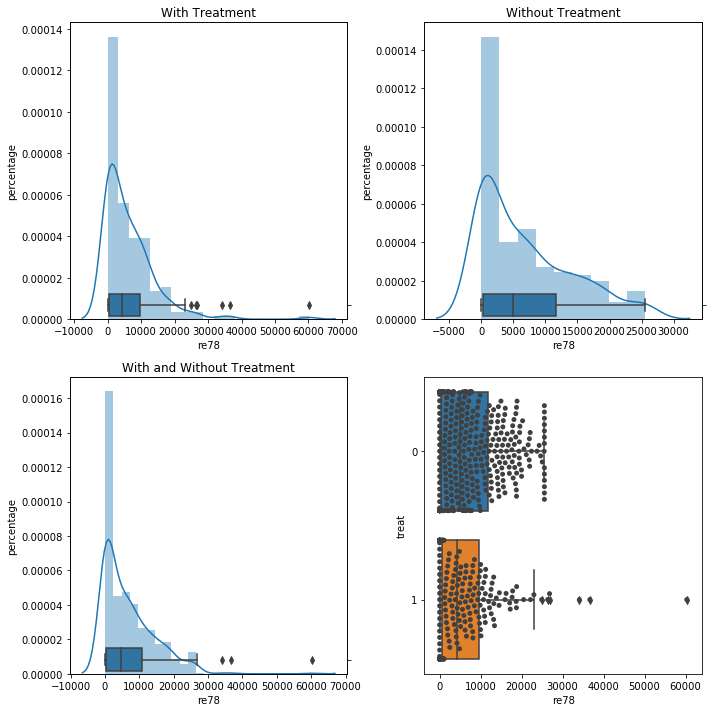

In [44]:
plot_distritbution_for_col(data, "re78")


**Looking at the data description and boxplot :**

Given the average revenues it would even seem that following the training program actually has a negative impact. Looking at the boxplot it would even seem that a larger portion of people suffer from lower salaries (looking at the difference between q3 and q1). However there are certain outlyers with significantly higher salaries when having followed the training program. This may be that there are certain people which benefitted significantly from the traning program.

**Looking at the histograms **

It is evident that a significant number of people do not have a job. This could potentially be biasing the results. We can also note that the distributions are not normal which can also be seen in the statistical tests where the null hypothesis is rejected when testing normality

**Looking at the statistical results :**

Both treatment and no treatment come from the same distribution. This could indicate that there is no difference between having taken the treatment or not. To compute the correlation we must use a non parametric correlation method such as the spearman correlation. This correlation is quite low (-0.04) which would indicate that there is no link between the revenue in 78 and having followed the training program. 

### 1.2. Closer Look

Using the functions above we were able to plot the distributions for both categorical and non categorical variables. We used the describe functionaliy of the dataframes to obtain certain parametric and non parametric measures. 

**Categorical Features**

       black  white  hispan  nodegree  married
treat                                         
0         87    281      61       256      220
1        156     18      11       131       35


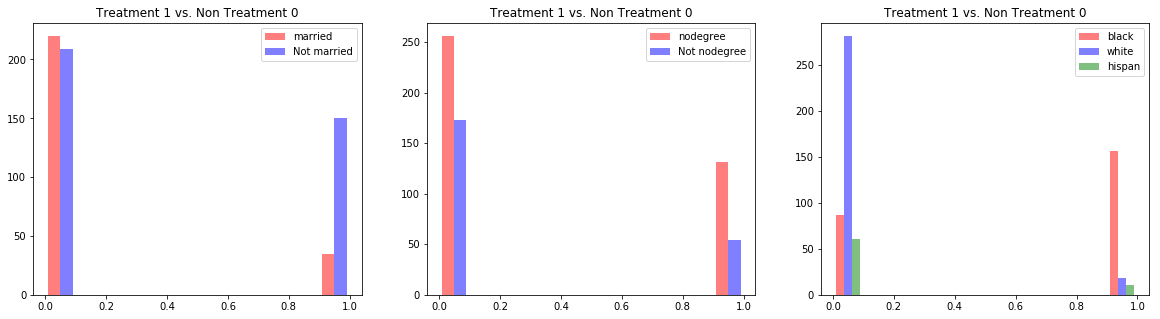

In [113]:
plot_distributions_for_categorical_variables(data)

Looking at how many people followed the seminar we can quickly see that none of the treatment vs. no treatment for the different categories are balanced neither in terms of count, average or distribution. This is something that will be addressed in part 4 of the exercise when matching. 

- Although there are a lot of whites in the study, less than 10% were part of the treatments.
- There are mainly black people who participated in the treatment 
- There are mainly unmarried people who followed the treatment
- Porportionally it would seem that there are as many people with and without degrees which participated in the treatment 

**Non categorical features**

In [163]:
for categ in ["age","educ", "re74", "re75", "re78"]:
    print(data[["treat",categ]].groupby("treat").describe())
    print("---------------------------------------------------------------------------------")

         age                                                    
       count       mean        std   min   25%   50%   75%   max
treat                                                           
0      429.0  28.030303  10.786653  16.0  19.0  25.0  35.0  55.0
1      185.0  25.816216   7.155019  17.0  20.0  25.0  29.0  48.0
---------------------------------------------------------------------------------
        educ                                                 
       count       mean       std  min  25%   50%   75%   max
treat                                                        
0      429.0  10.235431  2.855238  0.0  9.0  11.0  12.0  18.0
1      185.0  10.345946  2.010650  4.0  9.0  11.0  12.0  16.0
---------------------------------------------------------------------------------
        re74                                                                  
       count         mean          std  min  25%       50%       75%       max
treat                                      

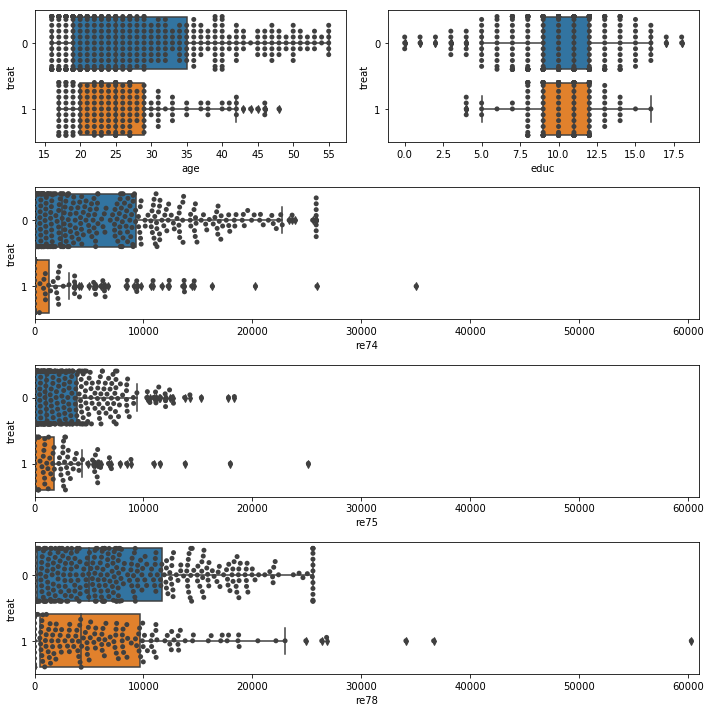

In [45]:
plot_distribution_for_non_categorical_variables(data)

Certain comments can already be made regarding the different features observed. In nearly all cases, the data is not normally distributed which is why it is important to consider non parametric metrics. That is why the boxplots are ideal to get a broad sense of what is going on in the data. Note that there may be a slight exception where the number of years of education is concerned though which seem to be part of the same distribution.

**More specifically :**
- In terms of age, the majority of people interviewed are below their 30s. The same goes for the number of people who did the training. 
- In terms of education, the majority of people interviewed are around 10 years of education. The same goes for the people who did the training. 
- Where the revenues are concerned
    - There are a significant number of people who had 0 revenue in the given years. This means that there are people who are unemployed throughout the entire period which is not suprising in the sense that there is a majority of people under 30 who are being interviewed. This means that at the time of treatment, most of them are most likely still studying and not looking for jobs. 
    - The control group experienced a general decrease in revenue between 74 and 75. This is most likely due to the oil crisis which experienced it's first peak around that time ([see here](https://en.wikipedia.org/wiki/1970s_energy_crisis#/media/File:Nominalrealoilprices1968-2006.png)). Their revenues increased significantly by 78 even though they had not participated in the training program. This could also be linked to a drop in the oil prices before the peak in the 80s.
    - Those who followed the training program essentially had revenues below 3000 dollars in 74 and 75. This is coherent with the fact that a majority of these people are young as mentioned previously and not necessarily looking for jobs. Therefore it would be logical to assume that in 78 when a larger fraction of people got jobs that their revenues would increase but that they would be lower than that of the control group where more people had jobs to begin with, especially since the salary is supposed to increase over time.
    - The outlyers we can see in the treatment group were already present in 74 and 75. 


**In general **
- between 74 and 78 : 
    - the control group saw their median salary go from 2500 to 5000. 
    - the treatment group saw their median salary go from 0 to 4200
    
- between 75 and 78 :
    - the control group saw their median salary go from 1100 to 5000. This is close to 5 times larger.
    - the treatment group saw their median salary fo from 0 to 4200. 

Therefore it would seem that the increase in salary is more significant for the group which followed the treatment compared to their salaries pre-treatment. This is therefore contradictory to what we saw in 1.1 when only observing the difference in salaries in 78. 


### 1.3. Propensity Score Model

Function used to compute the propensity scores 

In [166]:
def propensity_scores(df):
    treatment_features = ['age', 'black', 'white', 'hispan', 'educ', 'married', 'nodegree', 're74', 're75']
    treatment_class = 'treat'

    # The features vector
    X = pd.get_dummies(df[treatment_features])
    X.head(10)
    # The labels
    y = df[treatment_class].tolist()
    # The model
    logistic = LogisticRegression()
    # Fit the model to the data
    logistic.fit(X, y)
    # Predictions 
    pred = logistic.predict_proba(X)

    # Saving predictions to dataframe
    df["Probability of Treatment"] = pred[:,1]
    df["Estimated Treatment"] = np.where(df["Probability of Treatment"]>=0.5, 1, 0)

    return pred, y, df

In [51]:
prop_data = data.copy()
prop_data.reset_index(inplace = True)

treated = prop_data[prop_data['treat']==1]
control = prop_data[prop_data['treat']==0]

print("Treated {0}, Not Treated {1}".format(len(treated), len(control)))

Treated 185, Not Treated 429


As mentioned previously the classes are imbalanced which will be adressed in the next question 

[[362  67]
 [ 45 140]]
Normalized confusion matrix
[[ 0.84382284  0.15617716]
 [ 0.24324324  0.75675676]]
--------------------------
True Positive Rate: 0.5896
False Positive Rate: 0.0733
Precision : 0.8252
Recall : 0.8176
F1 Score: 0.8203


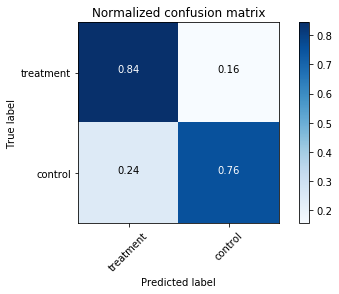

In [55]:
pred, labels, prop_data = propensity_scores(prop_data)
# Computing the confusion matrix
my_confusion_matrix(labels, prop_data["Estimated Treatment"].tolist(), ["treatment", "control"])


Looking at the normalized confusion matrix for the prediction labels we can see that with a simple non optimized threshold of 0.5 we can already obtain a realtively good estimation of whether a person was going to follow the training program or not. 

**Lookup how to read the confusion matrices again, especially in the case of unbalanced classes**

### 1.4. Balancing the Dataset Via Matching

http://jfinkels-networkx.readthedocs.io/en/latest/reference/algorithms/generated/networkx.algorithms.matching.max_weight_matching.html

In [53]:
def bipartite_matching(labels, pred):
    # Create a bipartite graph from the weighted adjacency matrix
    G=nx.Graph()

    idx_0 = [i for i in range(len(labels)) if labels[i] == 0] # not treated
    idx_1 = [i for i in range(len(labels)) if labels[i] == 1] # treated

    G.add_nodes_from(idx_0, bipartite=0) 
    G.add_nodes_from(idx_1, bipartite=1)

    # Adding the edges to the graph as the difference in propensity score
    for i in idx_0:
        for j in idx_1:
            G.add_edge(i,j,weight=1/((pred[i,1]-pred[j,1])**2+10**(-10)))

    # Use the networkx max_weight_matching algorithm on the graph in order 
    # to find the optimal pairs.
    matching = nx.max_weight_matching(G)

    # Removing permutations 
    new_matching = [[k,v] for k, v in matching.items()]
    new_matching = dict(set(tuple(sorted(pair)) for pair in new_matching))

    return new_matching

In [58]:
new_matching = bipartite_matching(labels, pred)

Retaining only the matched pairs

In [59]:
df_matched = data.reset_index()
df_matched = df_matched.loc[ list(new_matching.keys()) + list(new_matching.values())]
df_matched.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,race
17,NSW18,1,23,10,1,0,0,1,0.0000,0.000,7693.400,0,B
16,NSW17,1,27,13,1,0,0,0,0.0000,0.000,14581.860,0,B
134,NSW135,1,24,11,1,0,1,1,824.3886,1666.113,4032.708,0,B
108,NSW109,1,30,11,1,0,0,1,0.0000,0.000,0.000,0,B
167,NSW168,1,31,9,1,0,0,1,10717.0300,5517.841,9558.501,0,B


**Observing the distribution of the classes for non categorical variables**

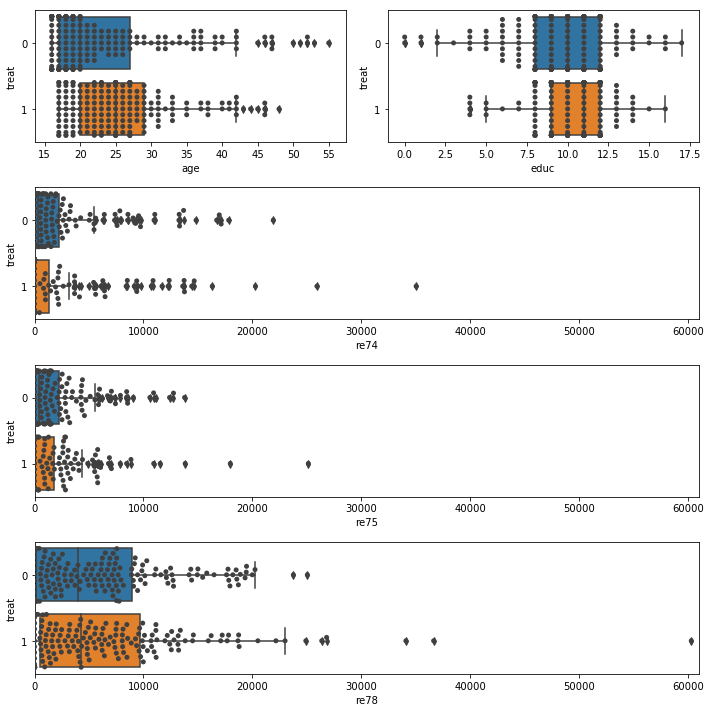

In [116]:
plot_distribution_for_non_categorical_variables(df_matched)

- Education and age follow similar distributions for both treated and non treated.
- Looking at the revenues in 74 and 75 between the treated and not treated class, they are equally well balanced

**Observing the distribution of the classes for categorical variables**

       black  white  hispan  nodegree  married
treat                                         
0         87     51      47       132       45
1        156     18      11       131       35


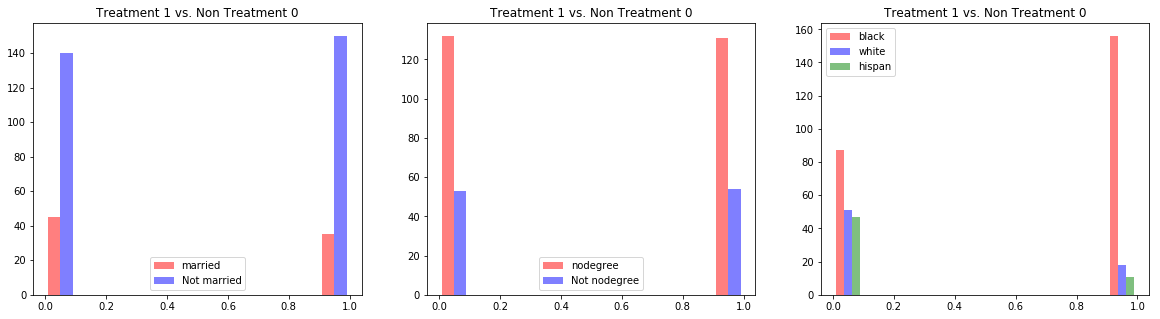

In [204]:
plot_distributions_for_categorical_variables(df_matched)

Observing the distribution of the different variables we see that there are about as many: 
- people who are married who followed the treatment as those who did not follow the treatment 
- people who are not married who followed and did not follow the treatment
- The same goes for the degrees. 

However, there is a big imbalance where the race is concerned which is why we need to force the matching at the level of the race. 

### 1.5. Balancing Groups Further


In [196]:
balanced_matching = {}

final_matching_df = pd.DataFrame(columns = data.columns)

for race in ["black", "white", "hispan"]:
    # Isolate the race from the dataframe
    race_df = data.loc[data[race] == 1]
    race_prop_data = race_df.copy()
    race_prop_data.reset_index(inplace = True)
    
    # Compute the propensity scores
    pred, labels, race_prop_data = propensity_scores(race_prop_data)
    
    # Do the matching
    balanced_matching[race] = bipartite_matching(labels, pred)
    
    # Store
    df_balanced_matching = race_df.reset_index()
    df_balanced_matching = df_balanced_matching.loc[list(balanced_matching[race].values()) \
                                                  + list(balanced_matching[race].keys())] 
    final_matching_df = pd.concat([final_matching_df, df_balanced_matching])

final_matching_df.set_index("id", inplace = True)   

Verifying whether all the individuals in the dataframe are only present once

In [197]:
final_matching_df.index.is_unique
final_matching_df.head()

,age,black,educ,hispan,married,nodegree,race,re74,re75,re78,treat,white
id,,,,,,,,,,,,
PSID191,18,1,12,0,0,0,B,1579.169,1408.9840,3057.4160,0,0
PSID24,47,1,8,0,1,1,B,9275.169,8543.4190,0.0000,0,0
PSID134,19,1,11,0,0,1,B,5607.422,3054.2900,94.5745,0,0
PSID256,17,1,8,0,0,1,B,0.000,451.1613,0.0000,0,0
PSID226,39,1,10,0,0,1,B,844.444,889.7903,701.9201,0,0


Recomputing the propensity scores for the new matching

[[82 34]
 [21 95]]
Normalized confusion matrix
[[ 0.70689655  0.29310345]
 [ 0.18103448  0.81896552]]
--------------------------
True Positive Rate: 0.1336
False Positive Rate: 0.0342
Precision : 0.7663
Recall : 0.7629
F1 Score: 0.7622


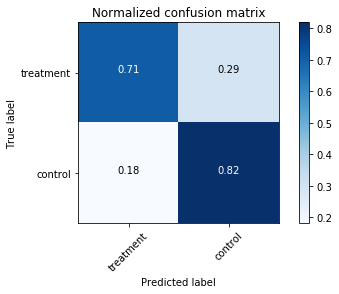

In [198]:
final_prop_data = final_matching_df.copy()
final_prop_data.reset_index(inplace = True)
pred, labels, final_prop_data = propensity_scores(final_prop_data)
# Computing the confusion matrix

final_prop_data["Estimated Treatment"] = np.where(final_prop_data["Probability of Treatment"]>=0.45, 1, 0)

my_confusion_matrix(labels, final_prop_data["Estimated Treatment"].tolist(), ["treatment", "control"])


Plotting the distributions for all variables

       black  white  hispan  nodegree  married
treat                                         
0         87     18      11        71       33
1         87     18      11        75       27


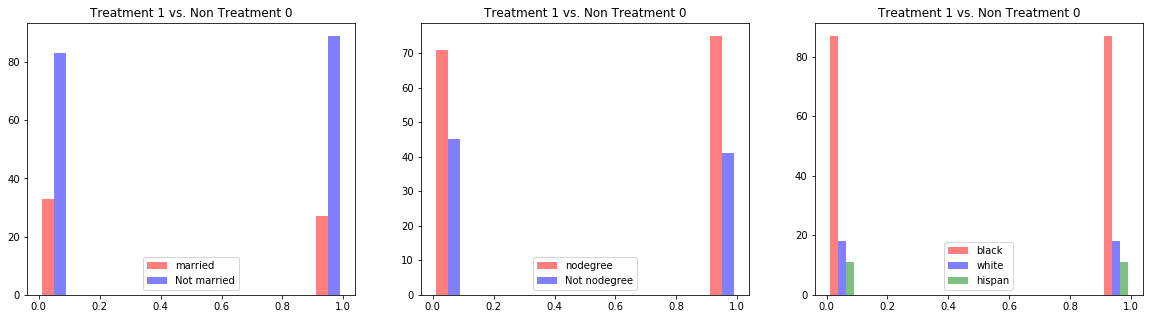

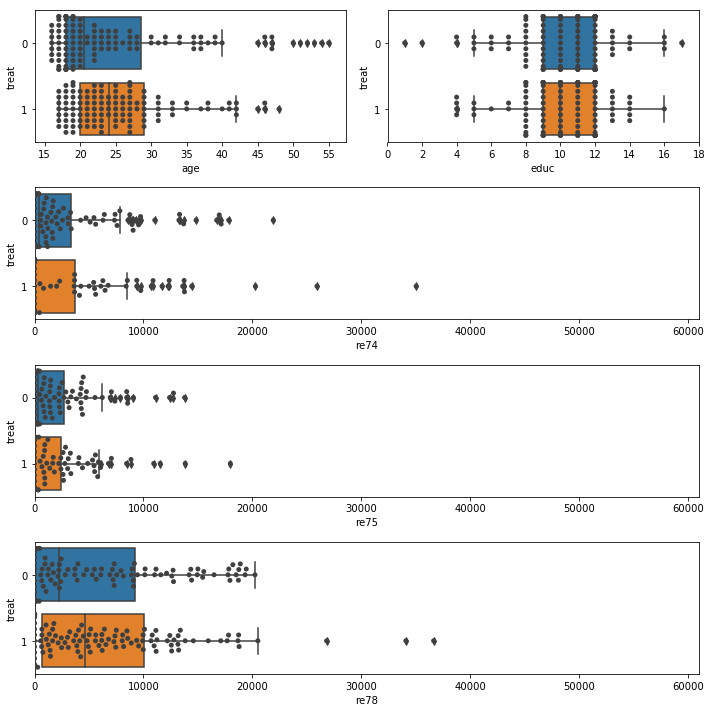

In [205]:
plot_distributions_for_categorical_variables(final_matching_df)
plot_distribution_for_non_categorical_variables(final_matching_df)

Although the F1 score for the propensity scores went down we can argue that the matching for all variables is generally more balanced
- For non categorical values this can be seen in the boxplots in terms of median as well as the 25% and 75% quartile. 
- For the categorical values we can see both in the counts and on the histograms that there is a good balance between all the categories for both treated and not treated (i.e. between married and non married, with and without education as well as race)


### 1.6. A Less Naive Analysis

In [194]:
final_matching_df = final_matching_df.apply(pd.to_numeric, errors='coerce').drop("race", axis = 1)

statistical_description(final_matching_df, "re78")

print("\nDescribing the data with parametric and non parametric metrics")

final_matching_df[["re78", "treat"]].groupby("treat").describe()

Testing whether the entire data is normally distributed
	The null hypothesis can be rejected

Testing whether the results with treatment are normally distributed
	The null hypothesis can be rejected

Testing whether the results without treatment are normally distributed
	The null hypothesis can be rejected

Testing whether the data comes from the same distributions
	The null hypothesis cannot be rejected

Computing correlation between Treatment and re78
	pearson correlation between treatment and re78 : 0.072162

Describing the data with parametric and non parametric metrics


re78                                                                \
       count         mean          std  min    25%        50%          75%   
treat                                                                        
0      116.0  5466.237758  6387.967527  0.0    0.0  2283.0875   9238.00775   
1      116.0  6430.382676  6982.675311  0.0  665.3  4648.7360  10011.04550   

                 
            max  
treat            
0      20243.38  
1      36646.95

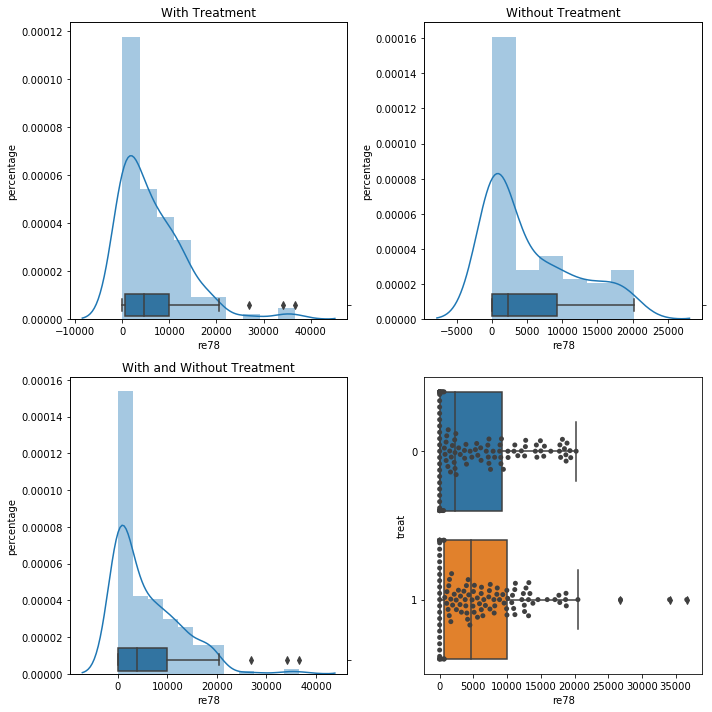

In [177]:
plot_distritbution_for_col(final_matching_df, "re78")

- Looking at the average and median it would seem that the treatment has a positive effect on the salary. Nonetheless the difference is less evident along the 25% and 75% quartile. 
- Looking at the distributions on the boxplots with the swarmplots confirms that the distributions are fairly similar. 
- Looking at the correlation between the treatment and the revenue we find a very small factor (7%). It would therefore seem that they are unrelated. 

Therefore it would seem that there is no statistically significant difference between the treatment and control groups which would indicate an efficiency of the treatment. 

___
___
___

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

___
___
___

**1. Loading the dataset **

We started by importing the news groups dataset for the scikit learn library. We isolated the data and the target names then we computed the term frequency inverse document frequency for each of the entries. This becomes our matrix of features X. We then split the dataset into training, validation and testing set using `np.split` function. We were careful to have a sparse array at the end in order to speed up the classification with the random forests. It is important to note that there are 170'000 features for 18'000 samples. Therefore it would have been interesting to do a preliminary feature selection before classification.

**2. Training and Classification With Random Forests **

To find the best parameters we ran a grid search as asked, although it would have been faster to run a random search using the scikit learn RandomSearchCV. We chose not to use the GridSearchCV function because the grid search Cv function outputs the solution with the best results while there is often a tradeoff to be made between the number of parameters / computation time and the accuracy. We wanted to be able to select the set of parameters which offered the best compromise which is why we output the results of the grid search in the form of a heatmap (accuracy on the validation set) before finding the best tradeoff. We then retrained the model with the optimal parameters, did the confusion matrix and assessed the results as well as the features selected.


### 1. Loading the Dataset

In [2]:
# Load the entire dataset from the website with shuffled ordering
newsgroups = fetch_20newsgroups(subset = "all")
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [3]:
# Computing the features 
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(newsgroups["data"])
# Labels
Y = newsgroups.target
# Mapping the indexes of targets to the names
targets_dict = {i:newsgroups['target_names'][i] for i in range(len(newsgroups['target_names']))}

As the data is already shuffled when loading with the fetching function, we can simply slice the arrays without randomizing the data first.

In [4]:
# Splitting the data into a training, testing and validation set
total = len(Y)
prop = int(np.ceil(0.1*len(Y)))
# Split the training data and the labels 
X_train, X_valid, X_test = np.split(X.toarray(), [total-2*prop, total-prop])
y_train, y_valid, y_test = np.split(Y, [total-2*prop, total-prop])

# Verifying the proportions for the training, validation and testing sets
print(len(X_train)/total, len(X_valid)/total, len(X_test)/total)

# Convert to sparse matrices
X_train, X_valid, X_test = sparse.csc_matrix(X_train), sparse.csc_matrix(X_valid), sparse.csc_matrix(X_test)

0.7999575506738831 0.10002122466305848 0.10002122466305848


### 2. Training and Classification With Random Forests

First a functions which are useful for the question :
- train the random forest classifier model given a training set, the desired number of estimators and the max depth
- test the given model on a given test set and output the accuracy
- run a grid serach on a training and testing set for a given range of estimators and max_depth parameters.

In [5]:
def train_model(X_train, y_train, num_estimators, max_depth):
    rf = RandomForestClassifier(n_estimators=num_estimators, max_depth = max_depth,\
                                random_state = 0)
    rf.fit(X_train, y_train)
    return rf

def test_model(X_test, y_test, rf):
    predicted = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return predicted, accuracy

def grid_search(estimators, depth, step, X_train, y_train, X_test, y_test):
    accuracy_scores = dict()
    accuracy_mat = np.zeros((max_num_est//step,max_num_depth//step))
    
    for n, n_estimators in enumerate(estimators):
        for md, max_depth in tqdm(enumerate(depth)):
            rf = train_model(X_train, y_train, n_estimators, max_depth)
            _,accuracy = test_model(X_valid, y_valid, rf)       
            accuracy_scores[(n_estimators, max_depth)]= accuracy
            accuracy_mat[n,md] = accuracy 
            
    return accuracy_scores, accuracy_mat

def plot_grid_search_results(accuracy_mat, estimators, depth):
    ax = sns.heatmap(accuracy_mat, annot=True)
    ax.set_xlabel("Estimators")
    ax.set_ylabel("Depth")
    ax.set_xticklabels(estimators,rotation=90)
    ax.set_yticklabels(depth,rotation=0)
    ax.set_title("Accuracy depending on the number of decision trees and max depth")

Starting off with a rough estimation of the accuracy over a limited set of parameters. 

In [6]:
max_num_est, max_num_depth, step = 1001, 1001, 200
estimators, depth = range(step,max_num_est,step), range(step,max_num_depth,step)

accuracy_scores, accuracy_mat = grid_search(estimators, depth, step, X_train, y_train, 
                                            X_valid, y_valid)


5it [31:57, 383.54s/it]
5it [1:04:43, 776.69s/it]
5it [1:45:49, 1269.90s/it]
5it [2:12:25, 1589.03s/it]
5it [2:58:13, 2138.76s/it]


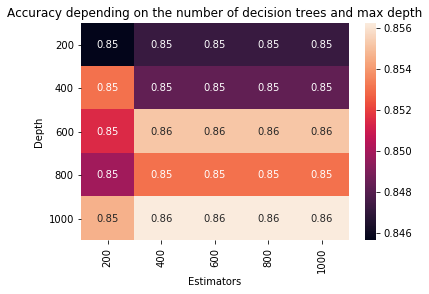

In [7]:
plot_grid_search_results(accuracy_mat, estimators, depth)

Looking at the results of the grid serach we can see that there is not much improvement in validation accuracy between 200 and 1000 estimators and or depth, the general tendency being around 0.85%. It is important to consider the tradeoff between performances and complexity of the model. It would therefore be sufficient to consider the performances of the model with estimators and depth in the range of 300. We conducted another grid search on this portion of the parameter space. 

In [8]:
max_num_est, max_num_depth, step = 300, 300, 10
estimators, depth = range(step,max_num_est,step), range(step,max_num_depth,step)

accuracy_scores, accuracy_mat = grid_search(estimators, depth, step, X_train, y_train, 
                                            X_valid, y_valid)


29it [15:20, 31.73s/it]
29it [12:38, 26.15s/it]
29it [13:18, 27.53s/it]
29it [18:05, 37.44s/it]
29it [21:04, 43.61s/it]
29it [25:21, 52.48s/it]
29it [29:59, 62.05s/it]
29it [34:25, 71.21s/it]
29it [37:55, 78.47s/it]
29it [42:30, 87.93s/it]
29it [46:35, 96.40s/it]
29it [51:25, 106.38s/it]
29it [54:35, 112.94s/it]
29it [59:45, 123.64s/it]
29it [1:03:44, 131.88s/it]
29it [1:42:50, 212.78s/it]
29it [1:54:10, 236.22s/it]
29it [1:21:07, 167.83s/it]
29it [1:28:52, 183.87s/it]
29it [1:40:18, 207.55s/it]
29it [1:39:45, 206.40s/it]
29it [1:38:20, 203.46s/it]
29it [2:01:46, 251.93s/it]
29it [12:07:25, 1505.00s/it]
29it [3:05:39, 384.13s/it]
29it [2:22:08, 294.08s/it]
29it [2:21:28, 292.72s/it]
29it [2:19:09, 287.92s/it]
29it [2:40:32, 332.16s/it]


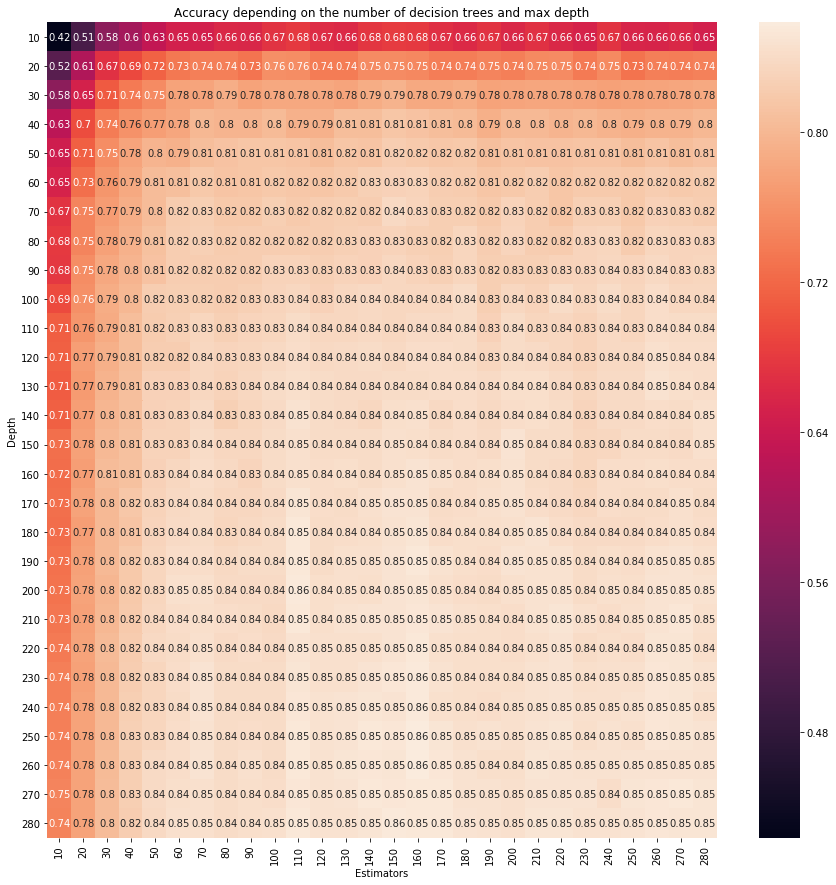

In [12]:
plt.figure(figsize = (15,15))
plot_grid_search_results(accuracy_mat[:-2,:-2], estimators, depth)

Here we can see more clearly how to performances evolve with respect to the selected parameters. Regarding the number of estimators we can see that there is no significant increase in performance beyond aournd 60 estimators. Good performances are obtained in terms of prediction for about 120 estimators and 120 of max depth. We re-ran the model with these parameters and computing the training, validation and testing accuracies.

In [17]:
opt_n_est,opt_max_depth = 120, 120
rf = RandomForestClassifier(n_estimators=opt_n_est, max_depth = opt_max_depth,\
                            random_state = 0)
rf.fit(X_train, y_train)

predicted_train, train_accuracy = test_model(X_train, y_train, rf)
predicted_valid, valid_accuracy = test_model(X_valid, y_valid, rf)
predicted_test, test_accuracy = test_model(X_test, y_test, rf)

print("Training Accuracy : {}".format(train_accuracy))
print("Validation Accuracy : {}".format(valid_accuracy))
print("Testing Accuracy : {}".format(test_accuracy))


Training Accuracy : 0.9998673388166622
Validation Accuracy : 0.8366047745358091
Testing Accuracy : 0.8509283819628647


We can clearly see that the model overfits during the training phase. In that case it is often useful to conduct a prior feature selection and or to reduce the number of paramters in the model. Considering the number of classes we get good results in terms of testing accuracy. 

Normalized confusion matrix
--------------------------
Precision : 0.8586
Recall : 0.8509
F1 Score: 0.8482


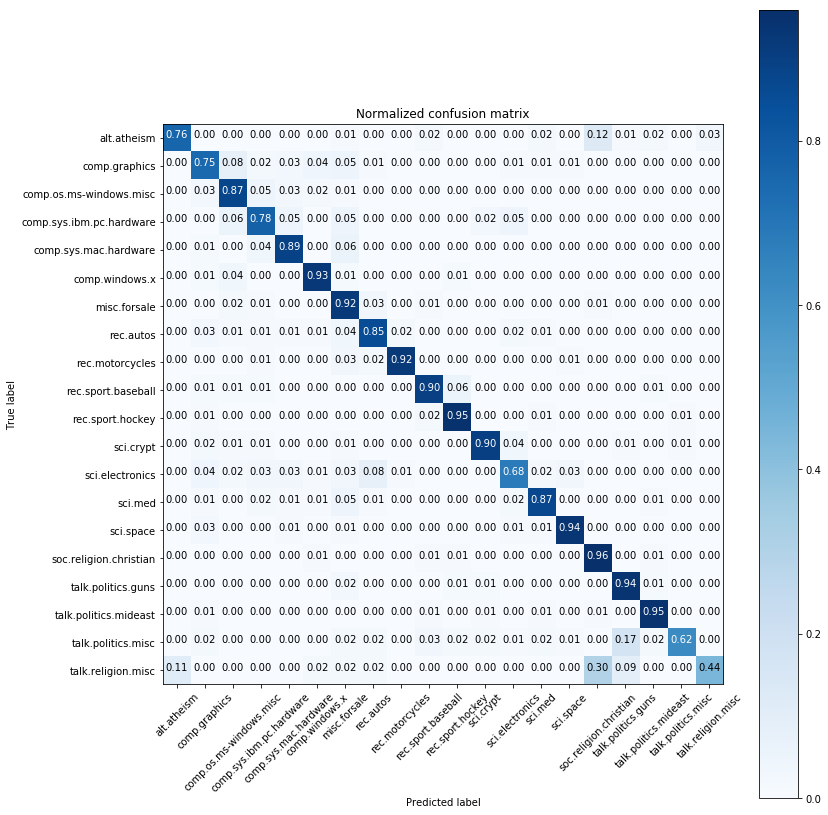

In [26]:
plt.figure(figsize = (12,12))
my_confusion_matrix(y_test, predicted_test, newsgroups['target_names'], print_cnf = False)

Looking more precisely into the confusion matrix, we can see that there is a big disparity in the classification. Certain categories are often well classified but there is some confusion regarding the following categories :
- alt.atheism : confused with sci-space
- comp.graphics, comp.op.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware and comp.windows-x are often miss-classified between each other
- rec.sport.baseball : confused with rec.sport.coffee
- sci-crypt : confused with sci.electronics
- sci.electronics: confused with comp.graphics, rec.autos and multiple others
- sci.med : confused with misc.forsale
- talk.politics.misc : confused with soc.religion.christian 
- talk.religion misc : confused with alt.atheism, sci.space, soc.religion.christian. 

When there are miss-classifications it is often justifiable in the sence that the topics are often closely related (either sports,religion or computer science). One could imagine that a person lambda would make the same mistakes. Other miss-classifications could also be due to the fact that the articles mention other topics (in the case of computer science) or criticize them (in the case of religion, politics etc...). 

In [38]:
# Recovering the number of relevant features
num_relevant_features = np.count_nonzero(rf.feature_importances_)
# Recovering the proportion of relevant features
prop_relevant_features = num_relevant_features/len(rf.feature_importances_)*100

print("Total number of features {}".format(len(rf.feature_importances_)))
print("Number of features with non zero importance {}".format(num_relevant_features))
print("Proportion of features with non zero importance : {:.1f} %".format(prop_relevant_features))
print("Highest importance obtained : {:.2f}%".format(max(rf.feature_importances_)*100))
print("Median importance obtained : {:.7f}%".format(np.median(rf.feature_importances_[rf.feature_importances_>0])*100))
print("Number of features of importance > 0.001% : {}".format(np.count_nonzero(rf.feature_importances_[rf.feature_importances_>0.001/100])))


Total number of features 173762
Number of features with non zero importance 54330
Proportion of features with non zero importance : 31.3 %
Highest importance obtained : 0.50%
Median importance obtained : 0.0002231%
Number of features of importance > 0.001% : 9882


Here we can see that only 31% of the features have any importance whatsoever in the classification process. That is why it is often useful to reduce the dimensionality of the data beforehand. The highest importance obtained by one given feature is 0.5% which is logical given the number of features remaining. Only 10'000 features of the original 170'000 have an importance which is superior to 0.001%. We can only stress the importance of doing prior feature selection and dimensionality reduction when creating the model. This can help reduce drastically the number of parameters (complexity of the model) and even improve the performances.